## Grad-CAM and RISE demo on YOLOv3+Keras 

In [45]:
import sys
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
base_path = '/mywork/PGDDS-IIITB/MyPractice'
proj_dir_path = os.path.join(base_path,"MyMScProj")
dataset_base_path = '/mywork/PGDDS-IIITB/MyDatasets'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

sys.path.append(base_path)
sys.path.append(proj_dir_path)

import tensorflow as tf


In [191]:
import numpy as np
from tensorflow.keras.models import load_model
from MyMScProj.jmod.utils import load_image_and_convert_scaled_pixels
from MyMScProj.jmod.onestage.yolov3.bbox import AnchorBox
#from MyMScProj.jmod.onestage.yolov3.inference import decode_yolo_netout, correct_yolo_boxes, draw_boxes
from MyMScProj.jmod.onestage.yolov3.inference import preprocess_input
from MyMScProj.jmod.utils import sigmoid, softmax
from MyMScProj.jmod.onestage.yolov3.bbox import BoundingBox
from matplotlib import pyplot
from matplotlib.patches import Rectangle




In [192]:
anchors=np.array([43,23,
 285,205,
 478,273,
 229,132,
 42,49,
 107,67,
 77,39,
 23,15,
 11,8])
ignore_thresh = 0.3
input_w, input_h = 416, 416
num_classes=11
batch_size=50
grid_scales=[1,1,1]
max_grid = [416, 416]
obj_scale = 5
noobj_scale = 1
xywh_scale = 1
class_scale = 1
warmup_batches = 1
max_box_per_image=34
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst5.h5')
saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst6.h5')

labels = ['articulated_truck', 'bicycle', 'bus', 'car',
           'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle',
           'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van']
test_img_dir = os.path.join(dataset_base_path,"MIO-TCD/MIO-TCD-Localization/test")

In [193]:
infer_model=load_model(saved_model_path, compile=False)  # default is True
print(infer_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [863]:
from keras import backend as K
import tensorflow as tf

K.clear_session()
import cv2
import matplotlib.pyplot as plt

#filename=os.path.join(test_img_dir,'00138488.jpg')
#filename=os.path.join(test_img_dir,'00137741.jpg')
filename=os.path.join(test_img_dir,'00137757.jpg') # busy evening with lots of cars in parking lot, and bus
#filename=os.path.join(test_img_dir,'00137833.jpg') # multiple trucks
#filename=os.path.join(test_img_dir,'00127972.jpg')
#filename=os.path.join(test_img_dir,'00127980.jpg')
#filename=os.path.join(test_img_dir,'00128345.jpg')
#filename=os.path.join(test_img_dir,'00138110.jpg') # road side offie parking lot
#filename=os.path.join(test_img_dir,'00136312.jpg') # prominent single white car
#filename=os.path.join(test_img_dir,'00136078.jpg') # person, car, bus
#filename=os.path.join(test_img_dir,'00136028.jpg') # variety of car, truck, trolly
#filename=os.path.join(test_img_dir, '00138078.jpg')
#filename=os.path.join(test_img_dir, '00137980.jpg') # bicycle
#filename=os.path.join(test_img_dir, '00137384.jpg') # city road plus human
#filename=os.path.join(test_img_dir, '00137860.jpg') # city road with parking lot vehicles
#filename=os.path.join(test_img_dir, '00137742.jpg') # small size image
#filename=os.path.join(test_img_dir, '00137860.jpg') 
#filename=os.path.join(test_img_dir, '00137734.jpg') # night bus
#filename=os.path.join(test_img_dir, '00136996.jpg') # human, bicycle
#filename=os.path.join(test_img_dir, '00136658.jpg') # small size image with lots of vehicle
#image, image_w, image_h = load_image_and_convert_scaled_pixels(filename,input_w, input_h)

os.path.basename(filename)

'00137757.jpg'

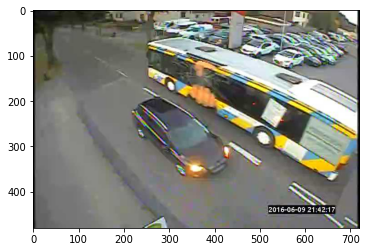

In [864]:
# see image before detection
#plt.figure(figsize=(12,11))
img_plt = cv2.imread(filename)
img_plt = cv2.cvtColor(img_plt, cv2.COLOR_BGR2RGB) 
image_w, image_h, _ = img_plt.shape
jm_image = preprocess_input(img_plt, input_w, input_h)
plt.subplot(1, 1, 1)
plt.imshow(img_plt)
plt.show()

In [735]:
print(jm_image.shape)
print(img_plt.shape)

(1, 416, 416, 3)
(480, 720, 3)


In [865]:
yolo_out = infer_model.predict(jm_image)
print([a.shape for a in yolo_out])

[(1, 13, 13, 48), (1, 26, 26, 48), (1, 52, 52, 48)]


In [866]:
from MyMScProj.jmod.onestage.yolov3.inference import decode_yolo_netout
boxes = list()
ignore_thresh=0.3
feats=yolo_out[0][0]
boxes += decode_yolo_netout(yolo_out[0][0], anchors[12:], ignore_thresh, input_h, input_w)
boxes += decode_yolo_netout(yolo_out[1][0], anchors[6:12], ignore_thresh, input_h, input_w)
boxes += decode_yolo_netout(yolo_out[2][0], anchors[:6], ignore_thresh, input_h, input_w)

In [867]:
def find_high_class_probability_bbox(netout_scale, obj_thresh):
    grid_h, grid_w = netout_scale.shape[:2]
    nb_box=3
    netout_scale = netout_scale.reshape((grid_h, grid_w, nb_box, -1))
    
    boxes = []
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row][col][b][5:]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row][col][b][:4]
                    confidence = netout_scale[row][col][b][4]
                    box = BoundingBox(x, y, w, h, confidence, classes)
                    if box.get_score() > obj_thresh:
                        boxes.append([x,y,w,h,confidence,classes])
    return(boxes)


In [868]:
def print_decoded_yolo_netout_res(netout, ignore_thresh, boxes ):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    thres_boxes=boxes
    print("Grid Scale {}x{}".format(grid_h,grid_w ))
    print("YOLO produces GRID_H * GRID_W * BOX = {} bounding boxes \
        ".format( grid_h * grid_w * nb_box))    
    print("found {} bounding boxes with top class probability > {}".format(len(thres_boxes),ignore_thresh))
    print("")


In [869]:
preds=list()
object_thres=0.4
scale13x_preds = find_high_class_probability_bbox(yolo_out[0][0], object_thres)
print_decoded_yolo_netout_res(yolo_out[0][0], object_thres, scale13x_preds)

scale26x_preds = find_high_class_probability_bbox(yolo_out[1][0], object_thres)
print_decoded_yolo_netout_res(yolo_out[1][0], object_thres, scale13x_preds)

scale52x_preds = find_high_class_probability_bbox(yolo_out[2][0], object_thres)
print_decoded_yolo_netout_res(yolo_out[2][0], object_thres, scale52x_preds)

Grid Scale 13x13
YOLO produces GRID_H * GRID_W * BOX = 507 bounding boxes         
found 3 bounding boxes with top class probability > 0.4

Grid Scale 26x26
YOLO produces GRID_H * GRID_W * BOX = 2028 bounding boxes         
found 3 bounding boxes with top class probability > 0.4

Grid Scale 52x52
YOLO produces GRID_H * GRID_W * BOX = 8112 bounding boxes         
found 2 bounding boxes with top class probability > 0.4



In [870]:
preds = scale13x_preds + scale26x_preds + scale52x_preds

In [871]:
#preds

In [872]:
len(preds)

25

In [873]:
pred_class_index=0
cnt=1
topNClassIndex=[]
for i in range(len(preds)):
    tmp_index = np.argmax(preds[i][5])
    if tmp_index != pred_class_index:
        pred_class_index = tmp_index
        if pred_class_index not in topNClassIndex:
            topNClassIndex.append(pred_class_index)
            print("predicted class:    Pr(Class={:20} [index={}])={:5.3f}".format(labels[pred_class_index],
                                                                                    pred_class_index,
                                                                                    preds[i][5][tmp_index]) )


            
print("Top class detected sort-by-index: ", np.sort(topNClassIndex))



predicted class:    Pr(Class=work_van             [index=10])=0.827
predicted class:    Pr(Class=car                  [index=3])=0.592
predicted class:    Pr(Class=bus                  [index=2])=0.876
Top class detected sort-by-index:  [ 2  3 10]


In [746]:
infer_model.inputs

[<tf.Tensor 'image_input:0' shape=(None, 416, 416, 3) dtype=float32>]

In [747]:
infer_model.output

[<tf.Tensor 'conv_81/BiasAdd:0' shape=(None, 13, 13, 48) dtype=float32>,
 <tf.Tensor 'conv_93/BiasAdd:0' shape=(None, 26, 26, 48) dtype=float32>,
 <tf.Tensor 'conv_105/BiasAdd:0' shape=(None, 52, 52, 48) dtype=float32>]

### Define YOLOv3 model for with convolution head for corresponding grid scale

In [748]:
from keras import models
from keras.layers import Input
#from keras.applications.vgg16 import preprocess_input
import keras

In [874]:
from keras import models
conv_name='conv_80'
#conv_name='conv_92'
#conv_name='conv_104'

last_conv_layer = infer_model.get_layer(conv_name)
last_conv_output = last_conv_layer.output
last_conv_layer_model = models.Model(infer_model.inputs, last_conv_output)
last_conv_layer_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [875]:
last_conv_layer_name = infer_model.get_layer(conv_name).name
last_conv_layer_scale = infer_model.get_layer(conv_name).get_output_at(0).get_shape()[1]
last_conv_layerNameScale = str(last_conv_layer_name) + "_scale" + str(last_conv_layer_scale) + "x"
print(last_conv_layerNameScale)

conv_80_scale13x


### Define Improvised Grad-Model for YOLOv3

In [791]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from keras.layers.merge import add, concatenate
from tensorflow.keras import models

In [792]:
def target_category_loss(x, category_index, nb_classes):
    #return tf.multiply(x, K.one_hot([category_index], nb_classes))
    arr=K.one_hot(category_index, nb_classes)
    onehot_sum_tf=tf.constant(np.zeros((11, ), dtype=np.float32))
    for i in range(arr.shape[0]):
        onehot_sum_tf = tf.add(onehot_sum_tf, arr[i])
    return tf.multiply(x, onehot_sum_tf)

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [876]:
tf_image = tf.constant(jm_image)
nb_classes=len(labels)
category_index = topNClassIndex
#target_layer = lambda x: target_category_loss(x, category_index[0], nb_classes)
target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

In [877]:
category_index

[10, 3, 2]

In [795]:
# arr=K.one_hot(category_index, nb_classes)
# print(arr.shape)
# #print(len(arr))
# print(arr[0])
# print(arr[1])
# # # tf.add(arr[0], arr[1])
# # #tf.add_n(arr)


# onehot_sum_tf=tf.constant(np.zeros((11, ), dtype=np.float32))
# onehot_sum_tf
# for i in range(arr.shape[0]):
#     onehot_sum_tf = tf.add(onehot_sum_tf, arr[i])
# print(onehot_sum_tf)

In [841]:
conv_output =  [l for l in last_conv_layer_model.layers if l.name == last_conv_layer_name][0].output
conv_output

<tf.Tensor 'conv_92/Conv2D:0' shape=(None, 26, 26, 512) dtype=float32>

In [842]:
flattenConv=Conv2D(11, 1, activation='linear')(last_conv_layer_model.output)
flat = Flatten()(flattenConv)
fc = Dense(11, activation='softmax')(flat)
lambda_layer_last = Lambda(target_layer, output_shape = target_category_loss_output_shape)(fc)
grad_model = models.Model(inputs=last_conv_layer_model.input, outputs=[conv_output, lambda_layer_last])
grad_model.summary()


Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
______________________________________________________________________________________

In [843]:
grad_model.output

[<tf.Tensor 'conv_92/Conv2D:0' shape=(None, 26, 26, 512) dtype=float32>,
 <tf.Tensor 'lambda_3/Mul:0' shape=(None, 11) dtype=float32>]

### Grad-CAM 

In [799]:
with tf.GradientTape() as tape:    
    tape.watch(tf_image)    
    conv_outputs,predictions = grad_model(tf_image)
    loss=tf.reduce_mean(predictions)
grads = tape.gradient(loss, conv_outputs)


In [800]:
predictions

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.02535967, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00259549]], dtype=float32)>

In [801]:
# compute the guided gradients
# https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
castConvOutputs = tf.cast(conv_outputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

In [802]:
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
convOutputs = conv_outputs[0]
guidedGrads = guidedGrads[0]

In [803]:
# compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

In [804]:
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
#(w, h) = (image.shape[2], image.shape[1])
(w, h) = (img_plt.shape[1], img_plt.shape[0])
heatmap = cv2.resize(cam.numpy(), (w, h))

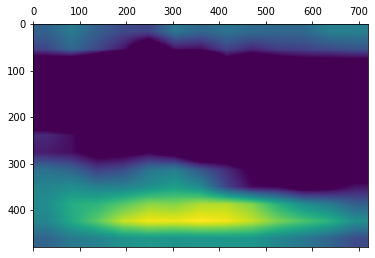

In [805]:
#heatmap = np.mean(conv_layer_output_val, axis=-1)

# normalize heatmap for visualization
heatmap=np.maximum(heatmap,0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)
plt.show()

### RISE

In [631]:
from PIL import Image
from tqdm import tqdm

In [878]:
grad_model=None
flattenConv=Conv2D(11, 1, activation='linear')(last_conv_layer_model.output)
flat = Flatten()(flattenConv)
fc = Dense(11, activation='softmax')(flat)
lambda_layer_last = Lambda(target_layer, output_shape = target_category_loss_output_shape)(fc)
grad_model = models.Model(inputs=last_conv_layer_model.input, outputs=lambda_layer_last)
#grad_model.summary()

In [879]:
print(last_conv_layer_model.output)
print(grad_model.output)

Tensor("conv_80/Conv2D:0", shape=(None, 13, 13, 1024), dtype=float32)
Tensor("lambda/Mul:0", shape=(None, 11), dtype=float32)


In [822]:
def load_image(path, preprocessing_function=None, target_size=(224, 224)):

    x = keras.preprocessing.image.load_img(path, target_size=target_size)
    x = keras.preprocessing.image.img_to_array(x)

    if preprocessing_function is not None:
        x = preprocessing_function(x)

    return x

# create a random mask
def create_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):

    # create random hxw mask
    mask = np.random.choice([0, 1], size=(h, w), p=[1 - p_1, p_1])

    # resize
    mask = Image.fromarray(mask * 255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # crop to HxW
    w_crop = np.random.randint(0, w + 1)
    h_crop = np.random.randint(0, h + 1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize
    mask /= np.max(mask)

    return mask


# create a weighted sum of masks
def create_sum_mask(masks, preds_masked, class_index):
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    for i, mask in enumerate(masks):
        m = mask * preds_masked[i][class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)

    return sum_mask

In [850]:
h = 7
w = 7
P_1 = 0.4
N_MASKS = 1000
IMAGE_SIZE = (416, 416, 3)

In [851]:
X = np.zeros((N_MASKS, ) + IMAGE_SIZE, dtype=np.float32)
masks = np.zeros((N_MASKS, ) + IMAGE_SIZE[:2], dtype=np.float32)

In [852]:
filename

'/mywork/PGDDS-IIITB/MyDatasets/MIO-TCD/MIO-TCD-Localization/test/00137741.jpg'

In [880]:
# generate masked images

img = load_image(
    filename,
    preprocessing_function=keras.applications.vgg16.preprocess_input,
    target_size=IMAGE_SIZE)

for i in tqdm(range(N_MASKS)):

    m = create_mask(h=h, w=w, H=IMAGE_SIZE[0], W=IMAGE_SIZE[1], p_1=P_1, resample=Image.BILINEAR)
    masks[i] = m
    x = img.copy()
    x[:, :, 0] *= m
    x[:, :, 1] *= m
    x[:, :, 2] *= m
    X[i] = x

  0%|          | 1/1000 [00:00<00:33, 29.75it/s]


ValueError: could not broadcast input array from shape (416,396) into shape (416,416)

In [881]:
X.shape

(1000, 416, 416, 3)

In [882]:
jm_image.shape

(1, 416, 416, 3)

In [883]:
pred_unmasked = grad_model.predict(jm_image)


In [884]:
preds_masked = grad_model.predict(X, verbose=1)

32/32 [==============================] - 166s 5s/step


In [724]:
#pred_unmasked[0]
preds_masked.shape
#preds_masked[0][category_index].shape

(1000, 11)

In [577]:
#preds_masked

In [578]:
print(masks.shape)
print(masks[0].shape)

(800, 416, 416)
(416, 416)


In [885]:
category_index

[10, 3, 2]

In [886]:
sum_mask = create_sum_mask(masks, preds_masked, category_index[0])

In [887]:
sum_mask

array([[0.7903822 , 0.7903822 , 0.7908464 , ..., 0.6576365 , 0.65815026,
        0.6603751 ],
       [0.7938487 , 0.7938487 , 0.78967035, ..., 0.661103  , 0.65647876,
        0.6587965 ],
       [0.7923464 , 0.7923464 , 0.7901799 , ..., 0.6597562 , 0.65536183,
        0.65834934],
       ...,
       [0.43706712, 0.44365996, 0.4394581 , ..., 0.23562919, 0.23534851,
        0.23526613],
       [0.43706712, 0.44365996, 0.44139266, ..., 0.23564722, 0.23513444,
        0.23686518],
       [0.43706712, 0.44365996, 0.44371405, ..., 0.23564722, 0.23513444,
        0.23875329]], dtype=float32)

In [888]:
sum_mask.shape

(416, 416)

In [889]:
(w, h) = (img_plt.shape[1], img_plt.shape[0])
rise = cv2.resize(sum_mask, (w, h))

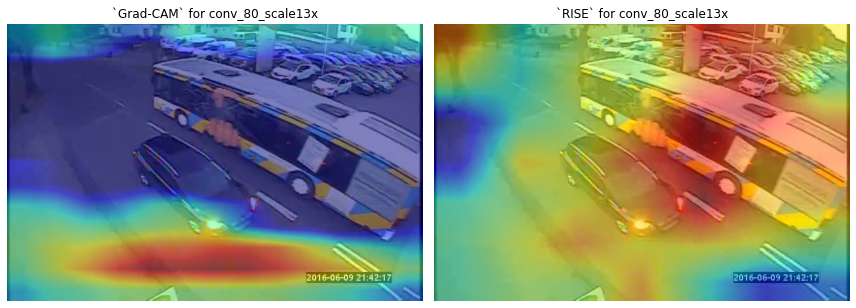

In [890]:
#plt.suptitle("Explanation for {}".format(last_conv_layerNameScale), fontsize=16)
fig = plt.figure(figsize=(12,8))
#fig = plt.figure()
#fig.suptitle("Explanation for {}".format(last_conv_layerNameScale), fontsize=16)


ax1=fig.add_subplot(121, frameon=True)
ax2=fig.add_subplot(122, frameon=True)

ax1.set_title('`Grad-CAM` for {}'.format(last_conv_layerNameScale))
ax1.set_axis_off()
ax1.imshow(img_plt)
ax1.imshow(heatmap,cmap="jet",alpha=0.5)

ax2.set_title('`RISE` for {}'.format(last_conv_layerNameScale))
ax2.set_axis_off()
ax2.imshow(img_plt)
ax2.imshow(rise,cmap="jet",alpha=0.5)

plt.tight_layout(h_pad=2)
# plt.subplots_adjust(top=0.95)
# plt.subplots_adjust(wspace=0.05)
#plt.suptitle("Explanation for {}".format(last_conv_layerNameScale), fontsize=12)
plt.savefig('/tmp/Grad-CAM_RISE-' +  last_conv_layerNameScale + "-" + os.path.basename(filename), dpi=300)

In [288]:
print(heatmap.shape)
print(img_plt.shape)

(480, 720)
(480, 720, 3)


In [108]:
from keras.applications.resnet50 import ResNet50
model=ResNet50()

102973440/102967424 [==============================] - 13s 0us/step


In [109]:
model.output

<tf.Tensor 'predictions/Softmax:0' shape=(None, 1000) dtype=float32>